In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [181]:
# Load datasets
sales_data = pd.read_csv("../Required Data/training_Sales.csv")
traffic_data = pd.read_csv("../Required Data/training_Traffic.csv")

In [213]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58437 entries, 0 to 58436
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    58437 non-null  datetime64[ns]
 1   Value   58437 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 913.2 KB


In [214]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67058 entries, 0 to 67057
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    67022 non-null  datetime64[ns]
 1   Value   67058 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.0 MB


In [184]:
print(sales_data.isna().sum())
print(traffic_data.isna().sum())

Date     0
Value    0
dtype: int64
Date     0
Value    0
dtype: int64


In [185]:
# Convert both Date columns to datetime format to ensure they match
traffic_data['Date'] = pd.to_datetime(traffic_data['Date'], errors='coerce')
sales_data['Date'] = pd.to_datetime(sales_data['Date'], format='%d/%m/%Y %H:%M', errors='coerce')

C:\Users\Chamodi\AppData\Local\Temp\ipykernel_11796\402421618.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_data['Date'] = pd.to_datetime(traffic_data['Date'], errors='coerce')


In [186]:
print(sales_data.isna().sum())
print(traffic_data.isna().sum())

Date     52
Value     0
dtype: int64
Date     36
Value     0
dtype: int64


In [187]:
print(sales_data['Date'].head())
print(traffic_data['Date'].head())

0   2021-01-01 10:00:00
1   2021-01-01 10:15:00
2   2021-01-01 10:30:00
3   2021-01-01 10:45:00
4   2021-01-01 11:00:00
Name: Date, dtype: datetime64[ns]
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: Date, dtype: datetime64[ns]


In [188]:
# Forward fill NaT values in the 'Date' column
sales_data['Date'] = sales_data['Date'].ffill()
print(sales_data['Date'].isna().sum())

traffic_data['Date'] = traffic_data['Date'].ffill()
print(sales_data['Date'].isna().sum())

0
0


In [189]:
# Perform the merge with custom suffixes
merged_data = pd.merge(sales_data, traffic_data, on='Date', how='right', suffixes=('_sales', '_traffic'))

In [190]:
merged_data

,Date,Value_sales,Value_traffic
0,NaT,NaN,758
1,NaT,NaN,718
2,NaT,NaN,758
3,NaT,NaN,834
4,NaT,NaN,691
...,...,...,...
67105,2023-01-01 12:00:00,7.0,821
67106,2023-01-01 11:45:00,5.0,810
67107,2023-01-01 11:30:00,2.0,798
67108,2023-01-01 11:15:00,3.0,729


In [191]:
print(merged_data.isna().sum())

Date                36
Value_sales      12787
Value_traffic        0
dtype: int64


In [194]:
# Forward fill NaT values in the 'Date' column
mean_date = merged_data['Date'].mean()
merged_data['Date'] = merged_data['Date'].fillna(mean_date)
print(merged_data['Date'].isna().sum())

0


In [195]:
merged_data['Value_sales'] = merged_data['Value_sales'].fillna(0)
print(merged_data['Value_sales'].isna().sum())

0


In [196]:
# Load and merge all holiday files (2021–2025)
holiday_files = [f'../Required Data/SL_Holidays/{year}.csv' for year in range(2021, 2026)]
holiday_df_list = [pd.read_csv(file) for file in holiday_files]
holiday_data = pd.concat(holiday_df_list, ignore_index=True)
holiday_data['Start'] = pd.to_datetime(holiday_data['Start'])
holiday_data['End'] = pd.to_datetime(holiday_data['End'])
holiday_data.drop_duplicates(inplace=True)

In [197]:
holiday_data.to_csv('../Required Data/merged_holiday_data.csv')

In [198]:
holiday_data.describe()

,Start,End
count,126,126
mean,2023-06-13 10:51:25.714285824,2023-06-14 10:51:25.714285824
min,2021-01-14 00:00:00,2021-01-15 00:00:00
25%,2022-04-13 06:00:00,2022-04-14 06:00:00
50%,2023-05-05 12:00:00,2023-05-06 12:00:00
75%,2024-09-09 00:00:00,2024-09-10 00:00:00
max,2025-12-25 00:00:00,2025-12-26 00:00:00


In [199]:
# Parse the 'Start' and 'End' columns in holiday data to datetime
holiday_data['Start'] = pd.to_datetime(holiday_data['Start'], errors='coerce')
holiday_data['End'] = pd.to_datetime(holiday_data['End'], errors='coerce')

In [200]:
# Check for rows with missing or invalid Date values in both datasets
#print(sales_data[sales_data['Date'].isna()])
#print(traffic_data[traffic_data['Date'].isna()])
print(merged_data[merged_data['Date'].isna()])

Empty DataFrame
Columns: [Date, Value_sales, Value_traffic]
Index: []


In [201]:
# Check if the 'Date' from merged_df is within the holiday periods
def check_holiday(date, holiday_data):
    for _, holiday in holiday_data.iterrows():
        if holiday['Start'] <= date <= holiday['End']:
            return 1  # It is a holiday
    return 0  # It is not a holiday

# Apply the function to the merged data
merged_data['is_holiday'] = merged_data['Date'].apply(lambda x: check_holiday(x, holiday_data))

In [202]:
# Ensure your datetime column is parsed
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

In [203]:
merged_data

,Date,Value_sales,Value_traffic,is_holiday
0,2023-02-13 08:15:49.284372224,0.0,758,0
1,2023-02-13 08:15:49.284372224,0.0,718,0
2,2023-02-13 08:15:49.284372224,0.0,758,0
3,2023-02-13 08:15:49.284372224,0.0,834,0
4,2023-02-13 08:15:49.284372224,0.0,691,0
...,...,...,...,...
67105,2023-01-01 12:00:00.000000000,7.0,821,0
67106,2023-01-01 11:45:00.000000000,5.0,810,0
67107,2023-01-01 11:30:00.000000000,2.0,798,0
67108,2023-01-01 11:15:00.000000000,3.0,729,0


In [204]:
# Convert the 'Date' column to the desired format: 'YYYY-MM-DD HH:MM:SS'
merged_data['Date'] = merged_data['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Check the result
print(merged_data.head())

                  Date  Value_sales  Value_traffic  is_holiday
0  2023-02-13 08:15:49          0.0            758           0
1  2023-02-13 08:15:49          0.0            718           0
2  2023-02-13 08:15:49          0.0            758           0
3  2023-02-13 08:15:49          0.0            834           0
4  2023-02-13 08:15:49          0.0            691           0


In [205]:
print(merged_data.isna().sum())

Date             0
Value_sales      0
Value_traffic    0
is_holiday       0
dtype: int64


In [206]:
#save the cleaned dataset to a csv file
output_file_path = "../Required Data/cleaned_dataset.csv"
merged_data.to_csv(output_file_path, index=False)

In [208]:
# Group by holiday vs non-holiday and calculate average sales
holiday_sales = merged_data.groupby('is_holiday')['Value_sales'].mean().reset_index()
holiday_sales['is_holiday'] = holiday_sales['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})

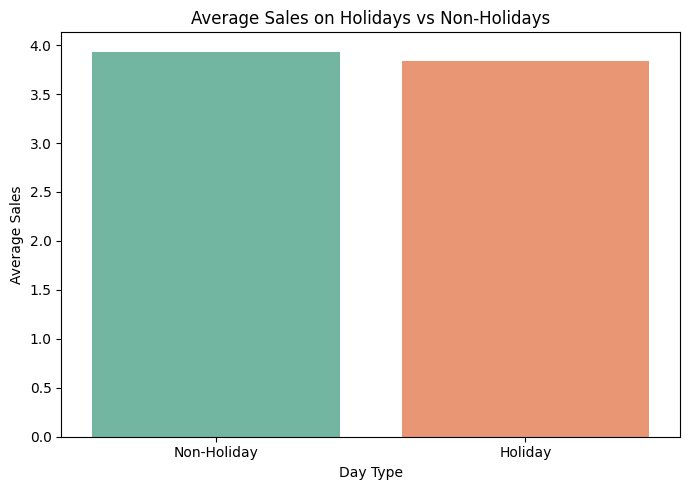

In [209]:
# Plot comparison
plt.figure(figsize=(7, 5))
sns.barplot(data=holiday_sales, x='is_holiday', y='Value_sales', palette='Set2')
plt.title('Average Sales on Holidays vs Non-Holidays')
plt.xlabel('Day Type')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


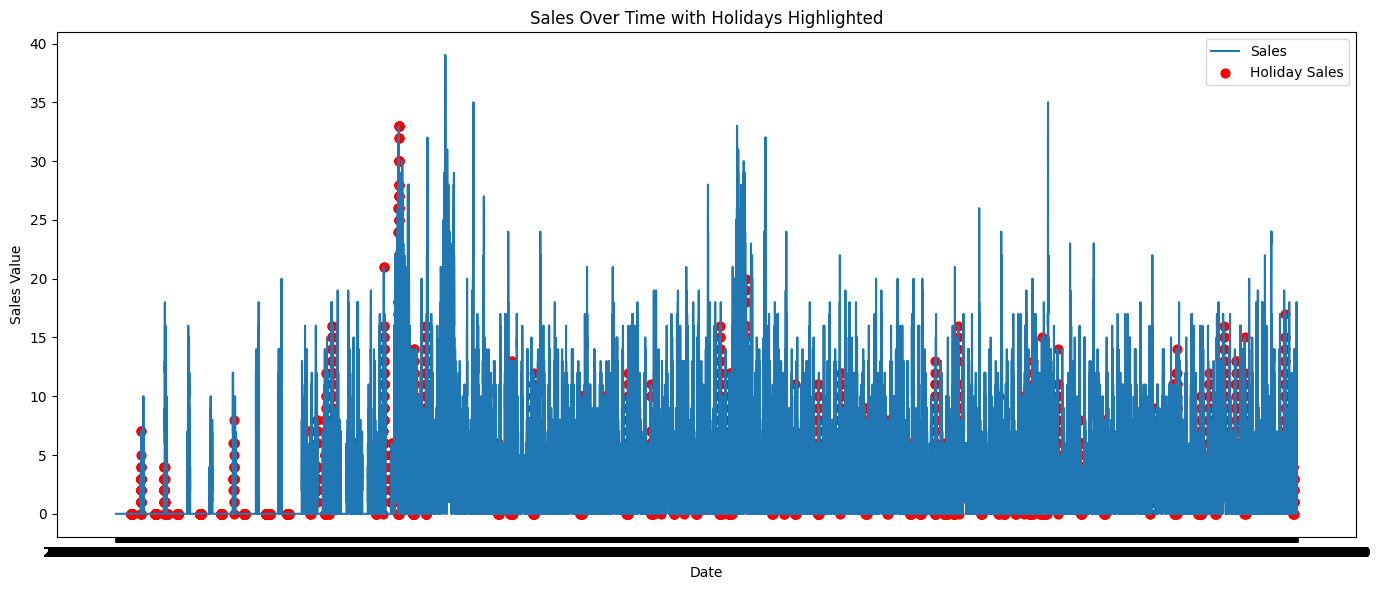

In [210]:
# Plot time series with holidays highlighted
plt.figure(figsize=(14, 6))
sns.lineplot(data=merged_data, x='Date', y='Value_sales', label='Sales')
plt.scatter(
    merged_data.loc[merged_data['is_holiday'] == 1, 'Date'],
    merged_data.loc[merged_data['is_holiday'] == 1, 'Value_sales'],
    color='red', label='Holiday Sales', s=40
)
plt.title('Sales Over Time with Holidays Highlighted')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.tight_layout()
plt.show()

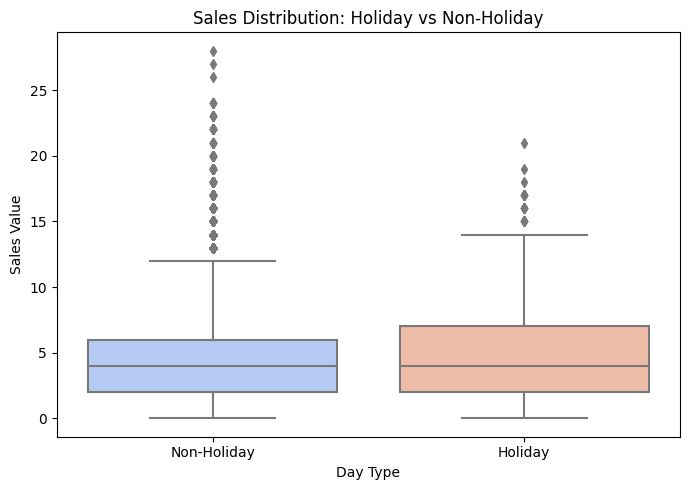

In [34]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x='is_holiday', y='Value_sales', palette='coolwarm')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.xlabel('Day Type')
plt.ylabel('Sales Value')
plt.tight_layout()
plt.show()

In [211]:
from scipy.stats import ttest_ind

# Separate sales into two groups
holiday_sales = merged_data[merged_data['is_holiday'] == 1]['Value_sales']
non_holiday_sales = merged_data[merged_data['is_holiday'] == 0]['Value_sales']

# Perform independent t-test
t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The difference in sales between holidays and non-holidays is statistically significant.")
else:
    print("🚫 The difference in sales between holidays and non-holidays is NOT statistically significant.")

T-statistic: -1.5459
P-value: 0.1222
🚫 The difference in sales between holidays and non-holidays is NOT statistically significant.
